In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [68]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output

In [3]:
tf.config.list_logical_devices('TPU')

2022-11-29 14:16:26.582340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 14:16:34.100926: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x88edce0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-11-29 14:16:34.100955: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-11-29 14:16:34.100963: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-11-29 14:16:34.100968: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-11-29 14:16:34.100973: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 39780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 9945 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Build layers for model


In [15]:

with strategy.scope():
    crop_layer = tf.keras.layers.Cropping2D(margin)
    #rescale_initial = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    rescale_initial = tf.keras.layers.Rescaling(1./255)
    conv_4to3_channel = tf.keras.layers.Conv2D(3,1,padding='same', activation='tanh')
    trained_base_model = tf.keras.applications.MobileNetV2(
        input_shape=(scaled_width,scaled_height,3),
        include_top=False,
        weights='imagenet'
    )
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(num_classes)

    trained_base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(img_width, img_height, 4))
    x = crop_layer(inputs)
    x = rescale_initial(x)
    x = conv_4to3_channel(x)
    x = trained_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
   
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
         patience=3,
         min_delta=0.001)
    
    model_fixed_base = tf.keras.Model(inputs, outputs)
    model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
    )

2022-11-29 14:21:27.166239: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-29 14:21:29.603662: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 4)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 4)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       15        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

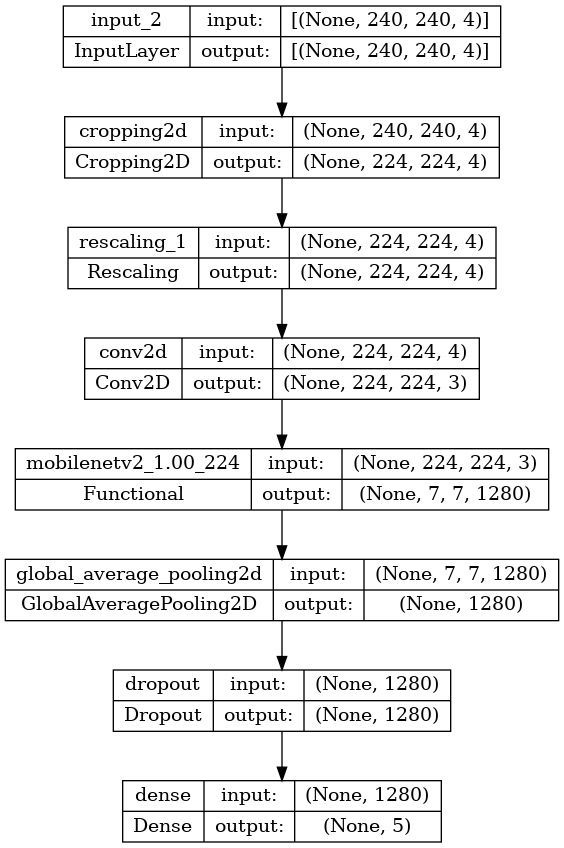

In [17]:
tf.keras.utils.plot_model(model_fixed_base, show_shapes=True)

In [18]:
small_model_epochs=80
history_model_fixed_base = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=small_model_epochs,
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-29 14:21:54.500430: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/80


2022-11-29 14:22:01.389850: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:7508030043732270841
2022-11-29 14:22:01.740131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:22:02.093908: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:22:06.626502: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(383136098441396369), session_name()


  2/622 [..............................] - ETA: 33s - loss: 1.3919 - accuracy: 0.1719    

2022-11-29 14:22:14.495917: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 383136098441396369 with session name  took 7.869260983s and succeeded
2022-11-29 14:22:14.560134: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(383136098441396369), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:22:14.560186: I tensorflow/c

415/622 [===================>..........] - ETA: 8s - loss: 1.5313 - accuracy: 0.3593

2022-11-29 14:22:32.057989: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4929269968073737045), session_name()


418/622 [===================>..........] - ETA: 11s - loss: 1.5346 - accuracy: 0.3593

2022-11-29 14:22:38.392678: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4929269968073737045 with session name  took 6.334589488s and succeeded
2022-11-29 14:22:38.419006: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4929269968073737045), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:22:38.419079: I tensorflow

622/622 [==============================] - ETA: 0s - loss: 1.5195 - accuracy: 0.3761

2022-11-29 14:22:47.001152: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-29 

622/622 [==============================] - 126s 172ms/step - loss: 1.5195 - accuracy: 0.3761 - val_loss: 1.2695 - val_accuracy: 0.4883


2022-11-29 14:24:01.431889: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 16409134106131111377 with session name  took 3.733693639s and succeeded
2022-11-29 14:24:01.445318: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(16409134106131111377), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_15450537635097717211", property.function_library_fingerprint = 10383662355163757858, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,240,240,4,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:24:01.445375: I tensorflow/

Epoch 2/80
622/622 [==============================] - 30s 48ms/step - loss: 1.3974 - accuracy: 0.4478 - val_loss: 1.1390 - val_accuracy: 0.5820
Epoch 3/80
622/622 [==============================] - 29s 46ms/step - loss: 1.3383 - accuracy: 0.4804 - val_loss: 1.1508 - val_accuracy: 0.5640
Epoch 4/80
622/622 [==============================] - 29s 47ms/step - loss: 1.3015 - accuracy: 0.5034 - val_loss: 1.2046 - val_accuracy: 0.5173
Epoch 5/80
622/622 [==============================] - 29s 47ms/step - loss: 1.2676 - accuracy: 0.5133 - val_loss: 1.0848 - val_accuracy: 0.6032
Epoch 6/80
622/622 [==============================] - 28s 45ms/step - loss: 1.2364 - accuracy: 0.5338 - val_loss: 1.0998 - val_accuracy: 0.5884
Epoch 7/80
622/622 [==============================] - 29s 46ms/step - loss: 1.2166 - accuracy: 0.5395 - val_loss: 1.1068 - val_accuracy: 0.5561
Epoch 8/80
622/622 [==============================] - 28s 44ms/step - loss: 1.2031 - accuracy: 0.5471 - val_loss: 1.0515 - val_accuracy:

In [19]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

In [20]:
#((activations[-1][1,:,:,:]+1)*127.5).astype('uint8')

1/1 [==============================] - 0s 26ms/step


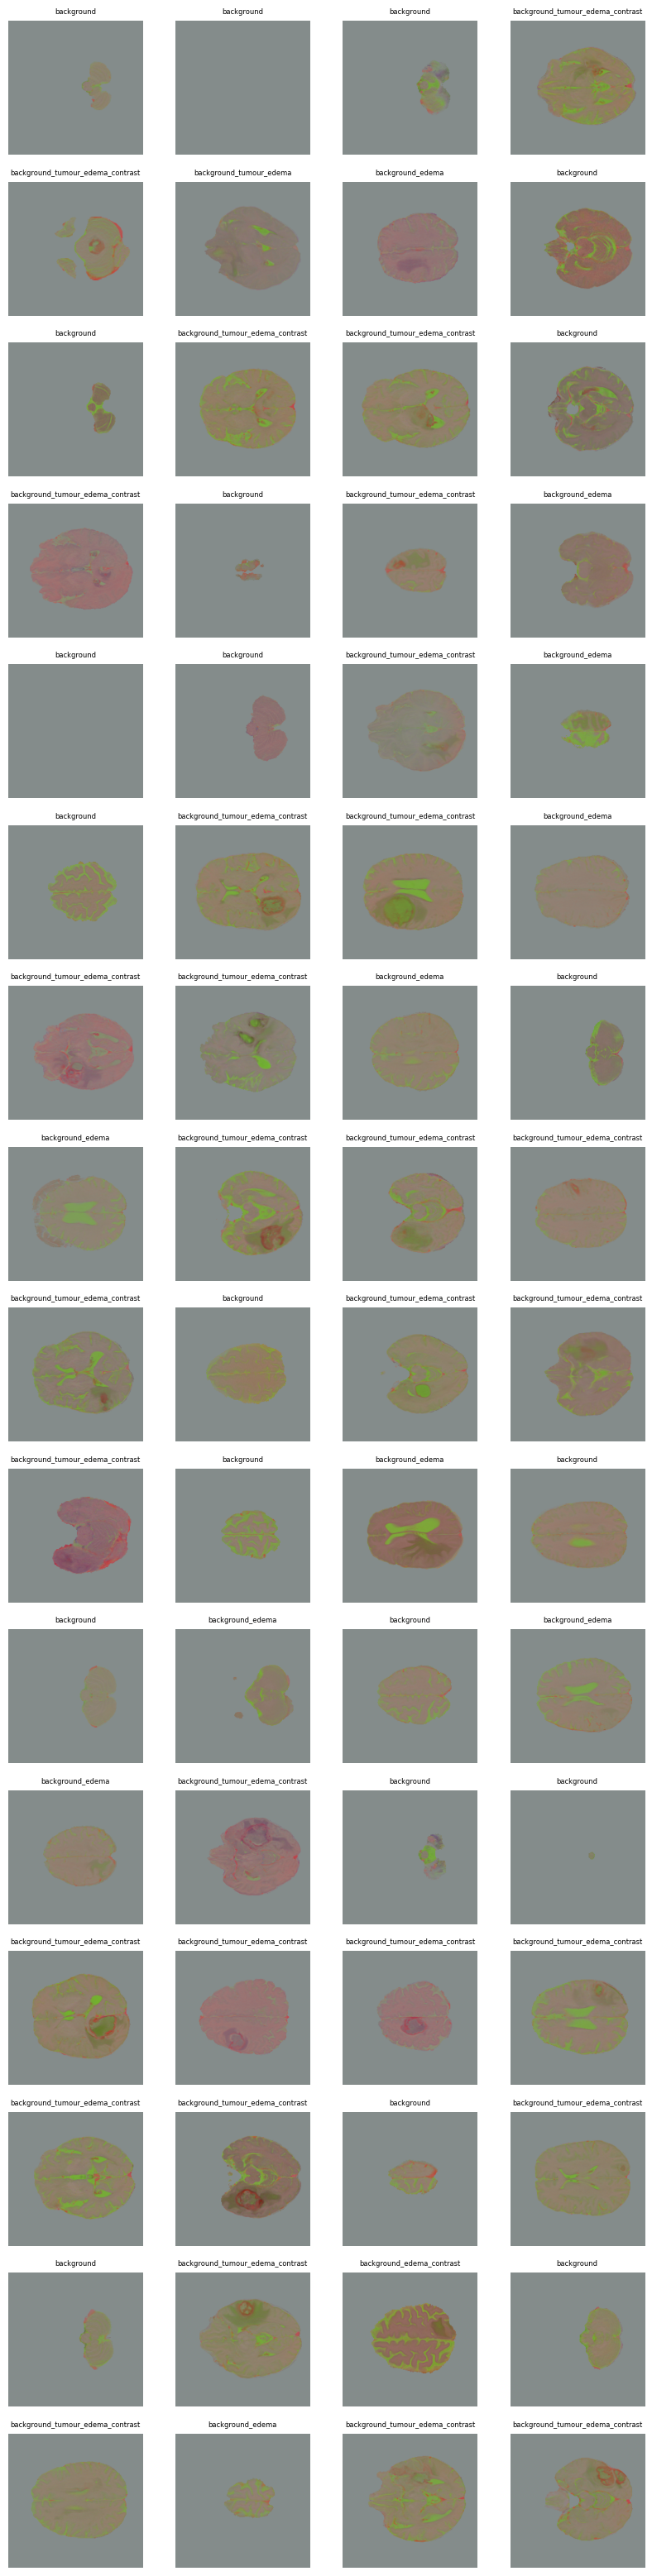

In [21]:
plt.figure(figsize=(10, 40))
batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

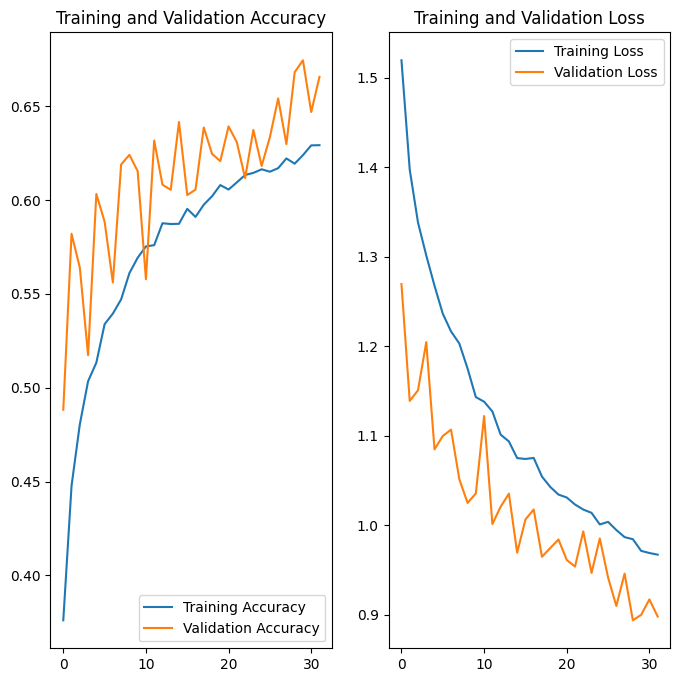

In [22]:
acc = history_model_fixed_base.history['accuracy']
val_acc = history_model_fixed_base.history['val_accuracy']

loss = history_model_fixed_base.history['loss']
val_loss = history_model_fixed_base.history['val_loss']

epochs_range = range(small_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
trained_base_model.trainable = True

In [24]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in trained_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [25]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )

In [26]:
fine_tuning_epochs=100
total_epochs = small_model_epochs + fine_tuning_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_model_fixed_base.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-29 14:39:22.857431: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 32/180


2022-11-29 14:39:32.331872: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:1399955724167508500
2022-11-29 14:39:32.784873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:39:33.160589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:39:33.826424: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4372114726580298631), session_name()


  3/622 [..............................] - ETA: 27s - loss: 1.2364 - accuracy: 0.5781    

2022-11-29 14:39:41.052290: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4372114726580298631 with session name  took 7.225740088s and succeeded
2022-11-29 14:39:41.092482: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4372114726580298631), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1399955724167508500", property.function_library_fingerprint = 9425000604112663439, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:39:41.092550: I tensorflow/

385/622 [=================>............] - ETA: 9s - loss: 1.0037 - accuracy: 0.6198

2022-11-29 14:39:57.068140: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(2253302594167214053), session_name()


388/622 [=================>............] - ETA: 14s - loss: 1.0053 - accuracy: 0.6197

2022-11-29 14:40:05.048920: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 2253302594167214053 with session name  took 7.980694404s and succeeded
2022-11-29 14:40:05.085797: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(2253302594167214053), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1399955724167508500", property.function_library_fingerprint = 9425000604112663439, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:40:05.085861: I tensorflow/

622/622 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.6247

2022-11-29 14:40:14.693396: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-29 

622/622 [==============================] - 59s 66ms/step - loss: 1.0079 - accuracy: 0.6247 - val_loss: 0.8670 - val_accuracy: 0.6746
Epoch 33/180
622/622 [==============================] - 30s 48ms/step - loss: 0.8948 - accuracy: 0.6558 - val_loss: 0.8540 - val_accuracy: 0.6644
Epoch 34/180
622/622 [==============================] - 30s 48ms/step - loss: 0.8078 - accuracy: 0.6777 - val_loss: 0.8605 - val_accuracy: 0.6794
Epoch 35/180
622/622 [==============================] - 30s 48ms/step - loss: 0.7441 - accuracy: 0.6969 - val_loss: 0.7525 - val_accuracy: 0.6867
Epoch 36/180
622/622 [==============================] - 30s 48ms/step - loss: 0.6835 - accuracy: 0.7139 - val_loss: 0.6367 - val_accuracy: 0.7439
Epoch 37/180
622/622 [==============================] - 30s 48ms/step - loss: 0.6287 - accuracy: 0.7300 - val_loss: 0.6571 - val_accuracy: 0.7374
Epoch 38/180
622/622 [==============================] - 30s 49ms/step - loss: 0.5863 - accuracy: 0.7482 - val_loss: 0.5988 - val_accuracy

In [27]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

1/1 [==============================] - 0s 30ms/step


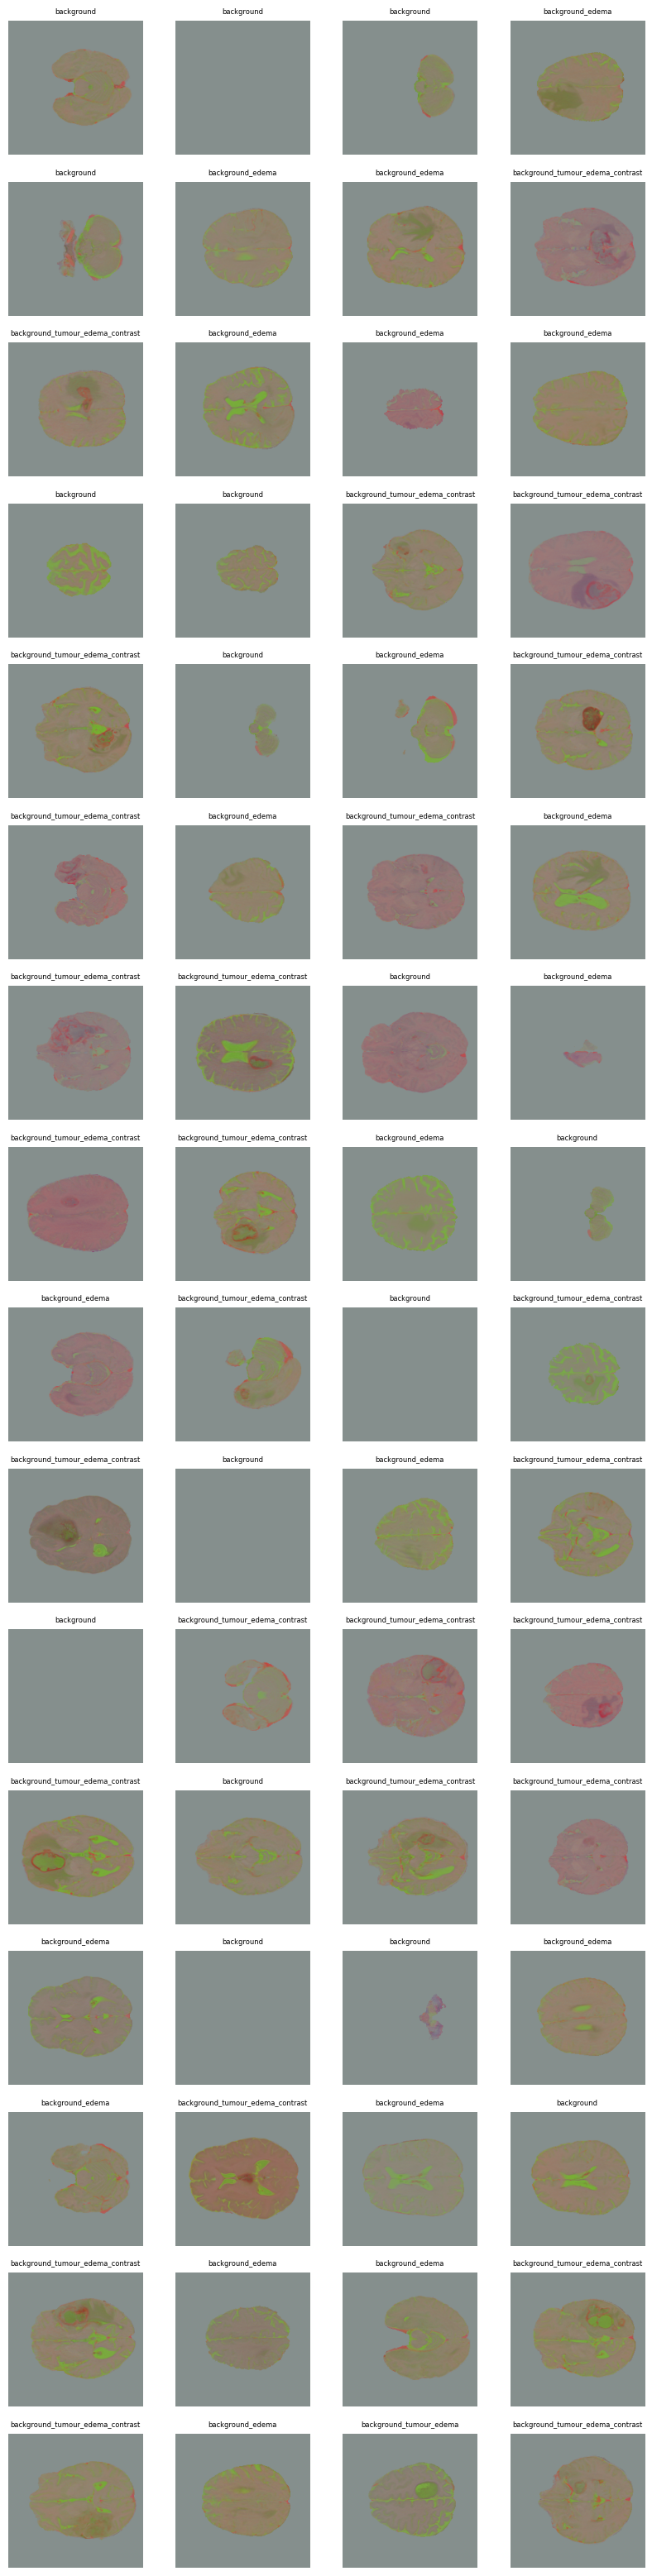

In [28]:
plt.figure(figsize=(10, 40))
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

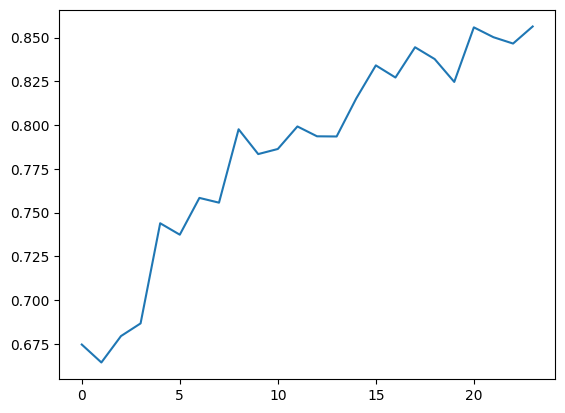

In [29]:
acc_fine = history_fine_tuning.history['val_accuracy']
loss_fine = history_fine_tuning.history['val_loss']
plt.plot(acc_fine)

In [30]:
trained_base_model.trainable = True
for layer in trained_base_model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [31]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )
  

In [32]:
full_relax_epochs=100
total_epochs += full_relax_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_fine_tuning.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-29 14:52:51.635384: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 55/280


2022-11-29 14:53:08.470521: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:10008876701896965541
2022-11-29 14:53:09.294441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:53:09.853168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-29 14:53:10.936740: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(898528621228758066), session_name()


  2/622 [..............................] - ETA: 34s - loss: 0.1556 - accuracy: 0.9062    

2022-11-29 14:53:23.938534: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 898528621228758066 with session name  took 13.001680163s and succeeded
2022-11-29 14:53:23.980578: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(898528621228758066), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10008876701896965541", property.function_library_fingerprint = 2895637832302738348, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:53:23.980640: I tensorflow/

565/622 [==========================>...] - ETA: 2s - loss: 0.2169 - accuracy: 0.8933

2022-11-29 14:53:53.565554: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(8470252402680450856), session_name()


567/622 [==========================>...] - ETA: 4s - loss: 0.2168 - accuracy: 0.8934

2022-11-29 14:54:07.422215: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 8470252402680450856 with session name  took 13.856548392s and succeeded
2022-11-29 14:54:07.476350: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(8470252402680450856), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10008876701896965541", property.function_library_fingerprint = 2895637832302738348, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 14:54:07.476424: I tensorflo

622/622 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.8931

2022-11-29 14:54:10.506941: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-29 

622/622 [==============================] - 85s 86ms/step - loss: 0.2170 - accuracy: 0.8931 - val_loss: 0.3969 - val_accuracy: 0.8550
Epoch 56/280
622/622 [==============================] - 37s 60ms/step - loss: 0.1849 - accuracy: 0.9071 - val_loss: 0.3628 - val_accuracy: 0.8695
Epoch 57/280
622/622 [==============================] - 38s 61ms/step - loss: 0.1761 - accuracy: 0.9131 - val_loss: 0.3643 - val_accuracy: 0.8641
Epoch 58/280
622/622 [==============================] - 37s 60ms/step - loss: 0.2133 - accuracy: 0.9011 - val_loss: 0.3522 - val_accuracy: 0.8729
Epoch 59/280
622/622 [==============================] - 38s 61ms/step - loss: 0.1638 - accuracy: 0.9216 - val_loss: 0.3421 - val_accuracy: 0.8775
Epoch 60/280
622/622 [==============================] - 37s 60ms/step - loss: 0.1376 - accuracy: 0.9314 - val_loss: 0.3386 - val_accuracy: 0.8813
Epoch 61/280
622/622 [==============================] - 38s 61ms/step - loss: 0.1444 - accuracy: 0.9288 - val_loss: 0.3337 - val_accuracy

1/1 [==============================] - 0s 25ms/step


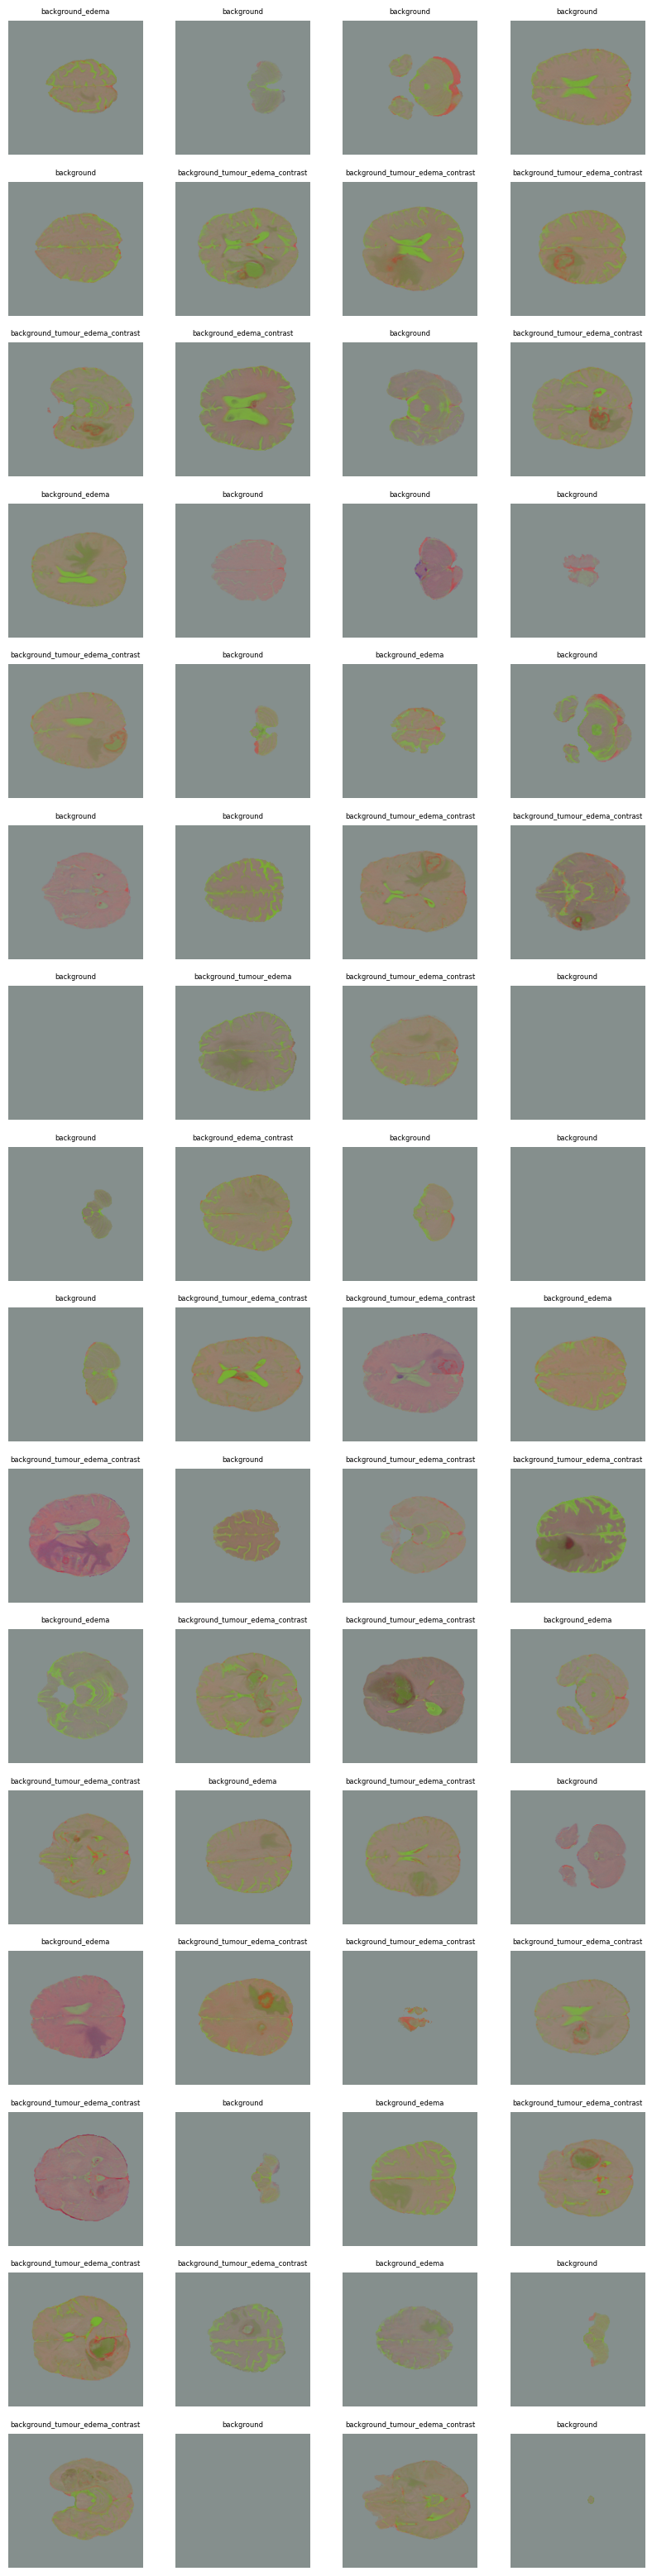

In [33]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

plt.figure(figsize=(10, 40))
#batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

In [34]:
for ch in range(3):

    print(
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).min(), 
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).max(), 
    )

113 140
123 151
67 141


In [35]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 4)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 4)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       15        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
tf.keras.utils.plot_model(trained_base_model)

In [38]:
with strategy.scope():
    # Use the activations of these layers
    pretrained_layer_name='mobilenetv2_1.00_224'
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [
        model_fixed_base.get_layer(pretrained_layer_name)
        .get_layer(name).output for name in layer_names
    ]

    # Create the feature extraction model
    down_stack = tf.keras.Model(
        inputs=model_fixed_base.get_layer(pretrained_layer_name).input, 
        outputs=base_model_outputs
    )

    down_stack.trainable = False

In [39]:
down_stack.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
#for layer in model_fixed_base.get_layer(pretrained_layer_name).layers[:-4]:
#    down_stack.get_layer(layer.name).set_weights(layer.get_weights())

In [ ]:
#down_stack.set_weights(model_fixed_base.get_layer(pretrained_layer_name).get_weights())

In [ ]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

In [40]:

# Define each layer block for upbranch
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  #elif norm_type.lower() == 'instancenorm':
  #  result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [41]:
up_stack = [
    upsample(512, 3),  # 7x7 -> 14x14
    upsample(256, 3),  # 14x14 -> 28x28
    upsample(128, 3),  # 28x28 -> 56x56
    upsample(64, 3),   # 56x56 -> 112x112
]

In [42]:
for layer in model_fixed_base.layers[1:4]:
    print(layer.name)

cropping2d
rescaling_1
conv2d


In [43]:
tensor = tf.convert_to_tensor(np.random.rand(64,240,240,4))
tensor

<tf.Tensor: shape=(64, 240, 240, 4), dtype=float64, numpy=
array([[[[0.45040566, 0.64955108, 0.56837665, 0.58690404],
         [0.89928011, 0.37124783, 0.80359599, 0.60724749],
         [0.85838833, 0.07579661, 0.13829355, 0.44792176],
         ...,
         [0.54642632, 0.72943428, 0.08249145, 0.84955252],
         [0.06713541, 0.35240794, 0.24928138, 0.35528368],
         [0.86100449, 0.96494946, 0.31453515, 0.95177114]],

        [[0.56100507, 0.35550492, 0.09770739, 0.34235747],
         [0.70967442, 0.31310614, 0.40083593, 0.27702768],
         [0.82093236, 0.93563738, 0.80594052, 0.02508272],
         ...,
         [0.63802188, 0.0185577 , 0.30222639, 0.41610776],
         [0.94826049, 0.26296268, 0.20354455, 0.15967071],
         [0.96507925, 0.65308835, 0.53735708, 0.2938994 ]],

        [[0.72442118, 0.33805297, 0.4638149 , 0.8832114 ],
         [0.60808058, 0.86910099, 0.40083959, 0.83479472],
         [0.49708002, 0.75633658, 0.27237162, 0.68914151],
         ...,
         [

In [44]:
#model.layers[2].input

In [45]:
def unet_model(output_channels: int):

    # Add layers from classification model
    inputs = tf.keras.layers.Input(shape=[240, 240, 4])
    x = model_fixed_base.layers[1](inputs)
    for layer in model_fixed_base.layers[2:4]:
        x = layer(x)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last_conv_trans = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding="same"
    )  # 64x64 -> 128x128

    x = last_conv_trans(x)

    x = tf.keras.layers.ZeroPadding2D(8)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [46]:
OUTPUT_CLASSES = 4
with strategy.scope():
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

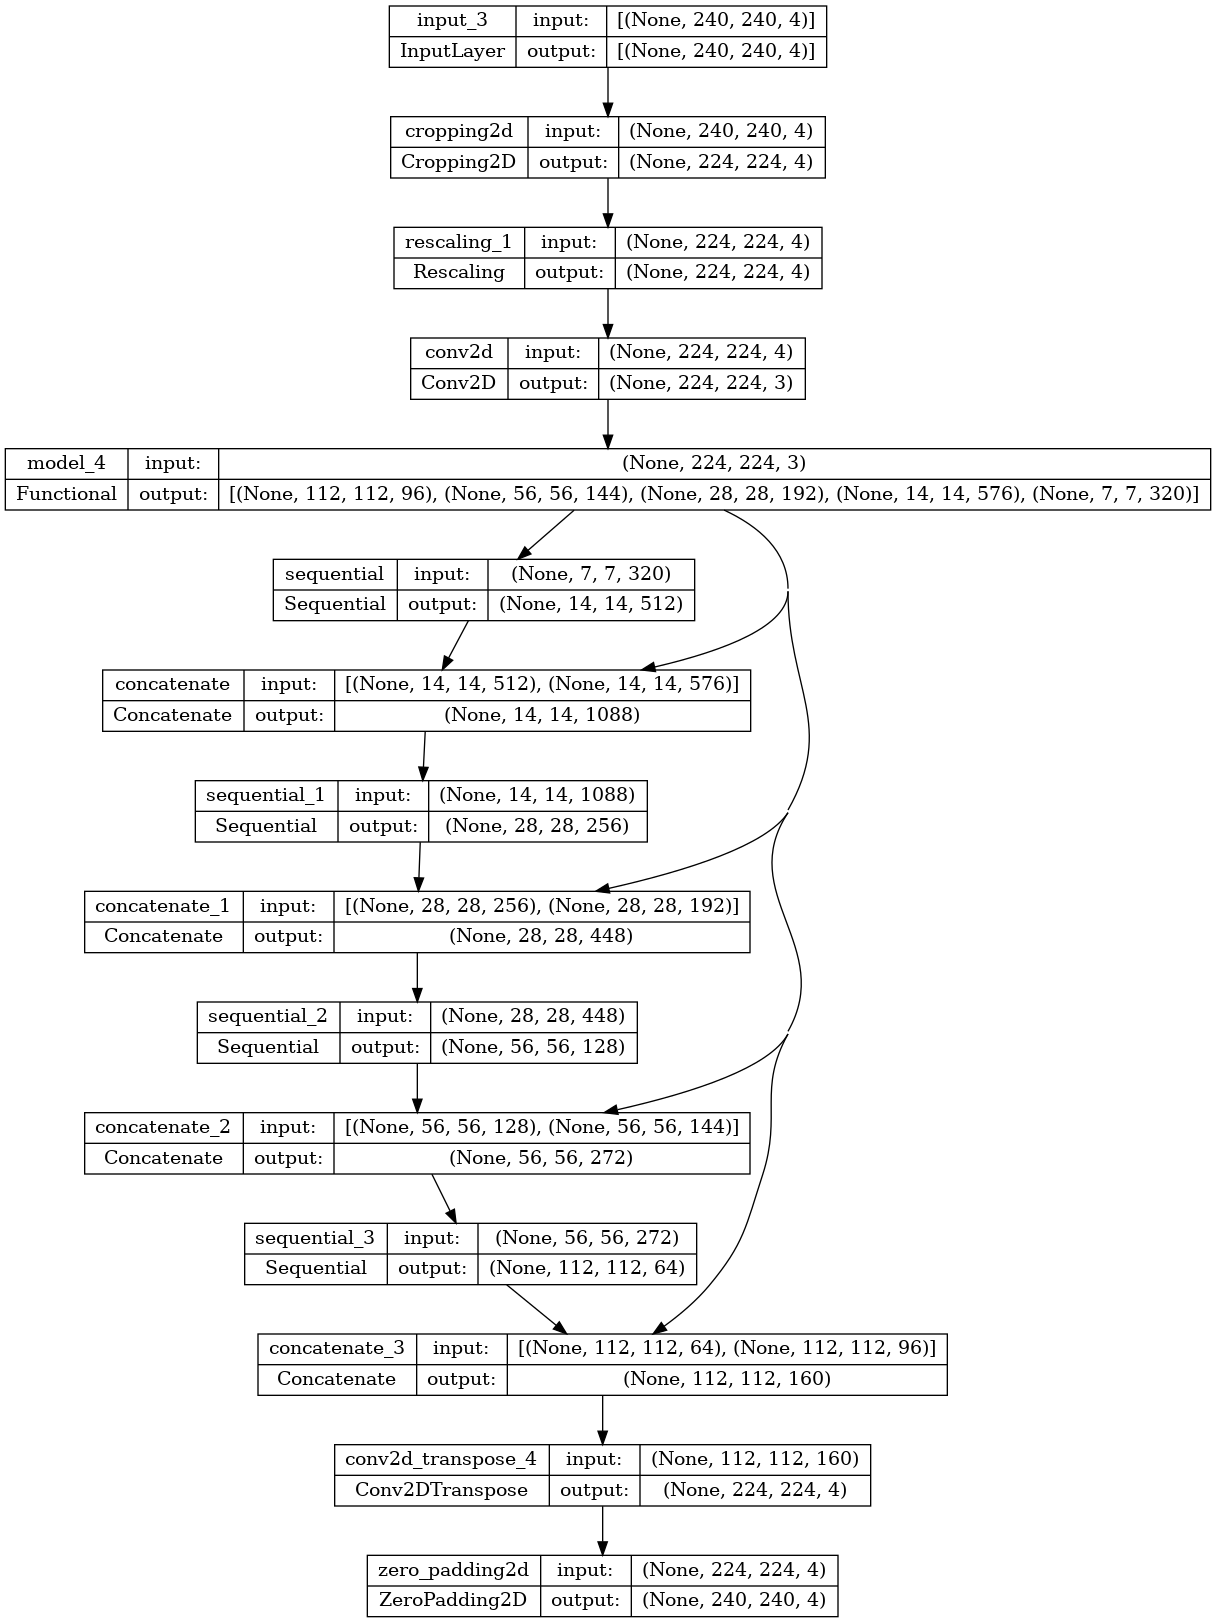

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [49]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','map_data')

for image_file in os.listdir(train_image_dir):
    map_file = image_file.replace('allseq', 'map')
    if not os.path.exists(os.path.join(train_map_dir,map_file)):
        raise FileNotFoundError((image_file, map_file))

    image = tf.io.read_file(os.path.join(train_image_dir,image_file))
    image = tf.io.decode_png(image, channels=4)
    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)

    # Convert map to make class integers contiguous
    seg_map = seg_map.numpy()
    seg_map[seg_map==4] = 3
    seg_map = tf.convert_to_tensor(seg_map)
    
    images.append(image)
    maps.append(seg_map)

In [50]:
train_images, val_images, train_maps, val_maps = train_test_split(images, maps, test_size=0.2)
train_images = tf.convert_to_tensor(train_images)
train_maps = tf.convert_to_tensor(train_maps)
val_images = tf.convert_to_tensor(val_images)
val_maps = tf.convert_to_tensor(val_maps)

In [64]:
val_images.shape

TensorShape([17019, 240, 240, 4])

In [51]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def create_dataset(img, seg_map, scaler):
    img = scaler(tf.cast(img, tf.float32))
    
    return img,seg_map

In [52]:
train_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(train_images,train_maps,scaler_neg1_1)
)
val_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(val_images,val_maps,scaler_neg1_1)
)

2022-11-29 15:59:14.654041: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.
2022-11-29 15:59:18.904382: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.
2022-11-29 15:59:23.189867: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.


In [53]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [55]:
train_batch = (
    train_data.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [62]:
val_batch = val_data.batch(BATCH_SIZE)

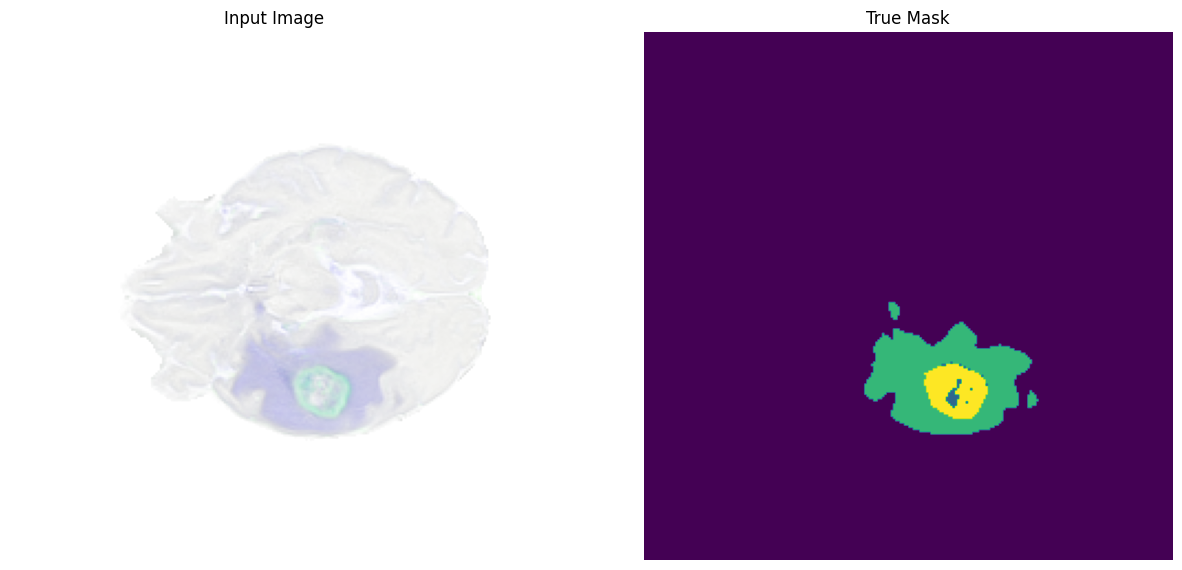

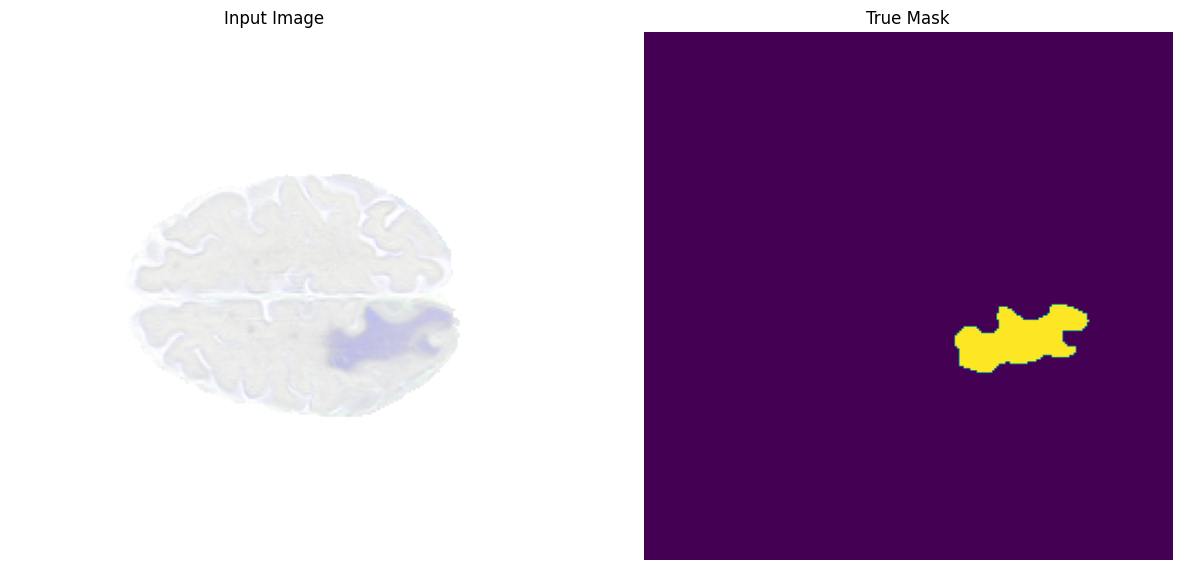

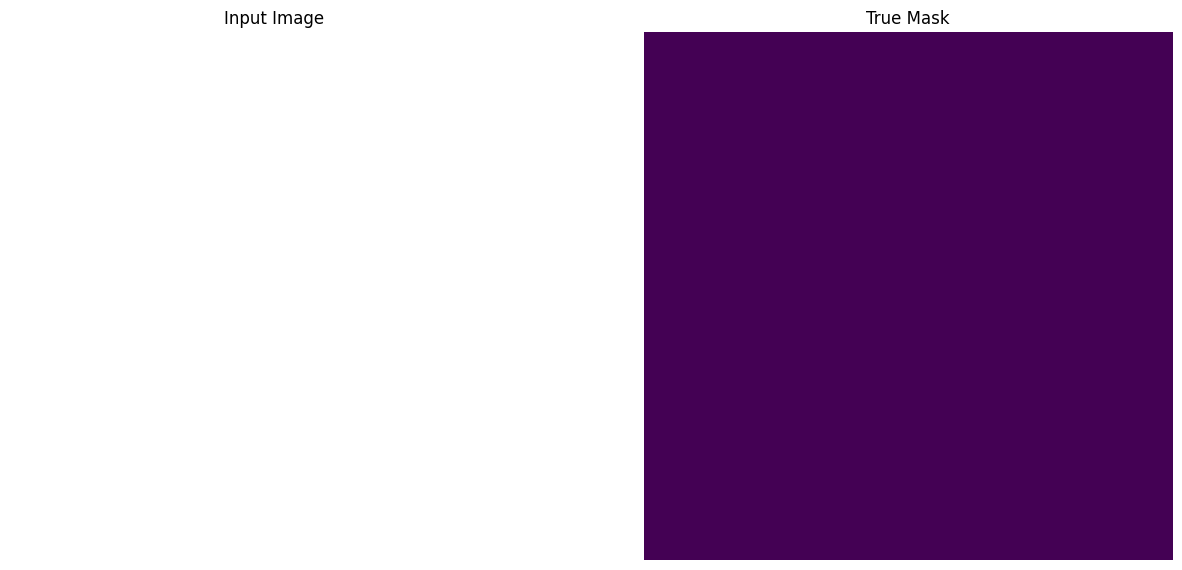

2022-11-29 16:10:41.589094: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [60]:
for images, masks in train_batch.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

2022-11-29 16:12:22.621743: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(6515367765404901901), session_name()


1/2 [==============>...............] - ETA: 5s

2022-11-29 16:12:27.808366: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 6515367765404901901 with session name  took 5.186438415s and succeeded
2022-11-29 16:12:27.823761: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(6515367765404901901), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_220814247986579694", property.function_library_fingerprint = 11590823179784857564, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 16:12:27.823819: I tensorflow/core

2/2 [==============================] - 1s 159ms/step


2022-11-29 16:12:33.104328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


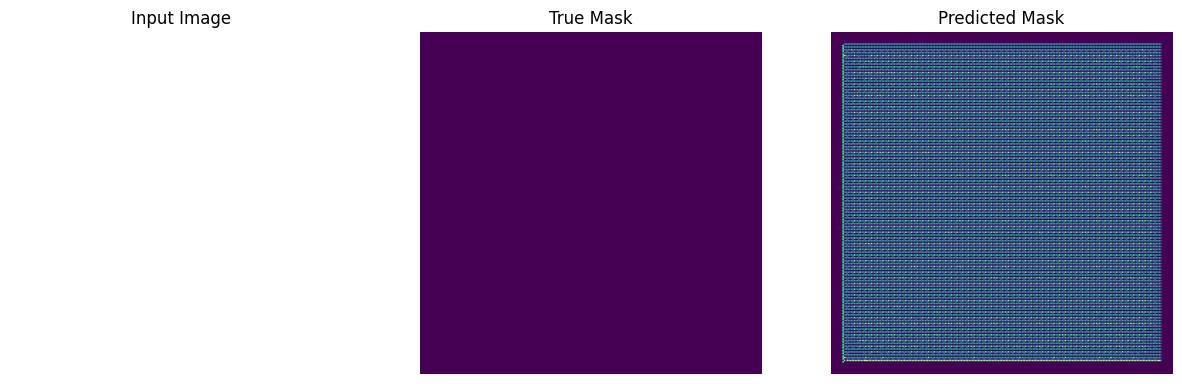

In [61]:
show_predictions(train_batch,6)

In [69]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 477ms/step


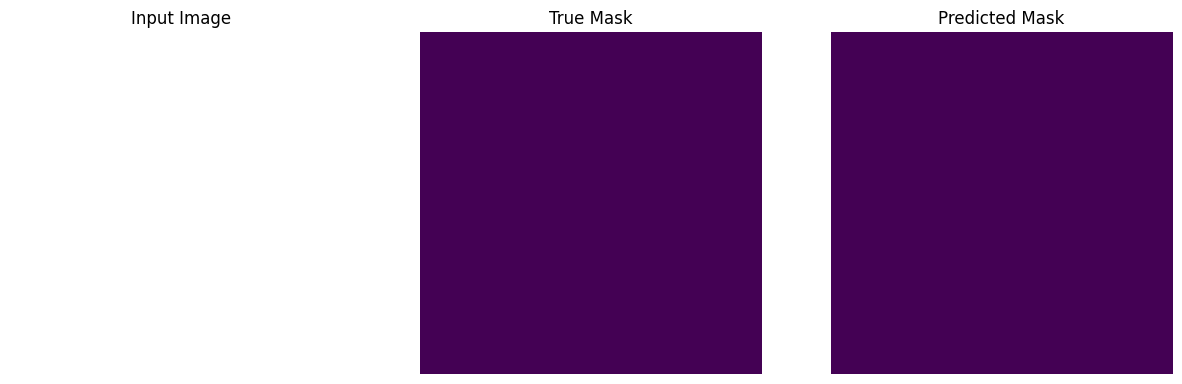


Sample Prediction after epoch 20

1063/1063 [==============================] - 91s 86ms/step - loss: 0.1849 - accuracy: 0.9978 - val_loss: 0.1891 - val_accuracy: 0.9968


In [70]:
TRAIN_LENGTH=68076
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 17019//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batch, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batch,
                          callbacks=[DisplayCallback()])

In [84]:
val_maps.shape

TensorShape([17019, 240, 240, 1])

In [93]:
single_img = tf.expand_dims(val_images[4],0)
single_map = tf.expand_dims(val_maps[4],0)


In [94]:
single_img.shape

TensorShape([1, 240, 240, 4])

In [101]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


In [102]:
for simg, smap in single_ds:
    print(simg.shape, smap.shape)

(1, 240, 240, 4) (1, 240, 240, 1)


2022-11-29 17:19:03.367931: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:15416739045138371964
2022-11-29 17:19:03.519207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-11-29 17:19:03.711652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-11-29 17:19:04.044726: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(6551866500279377597), session_name()


1/1 [==============================] - 8s 8s/step


2022-11-29 17:19:09.023934: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 6551866500279377597 with session name  took 4.979043205s and succeeded
2022-11-29 17:19:09.039449: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(6551866500279377597), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_15416739045138371964", property.function_library_fingerprint = 6829070999234211210, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-29 17:19:09.039508: I tensorflow/cor

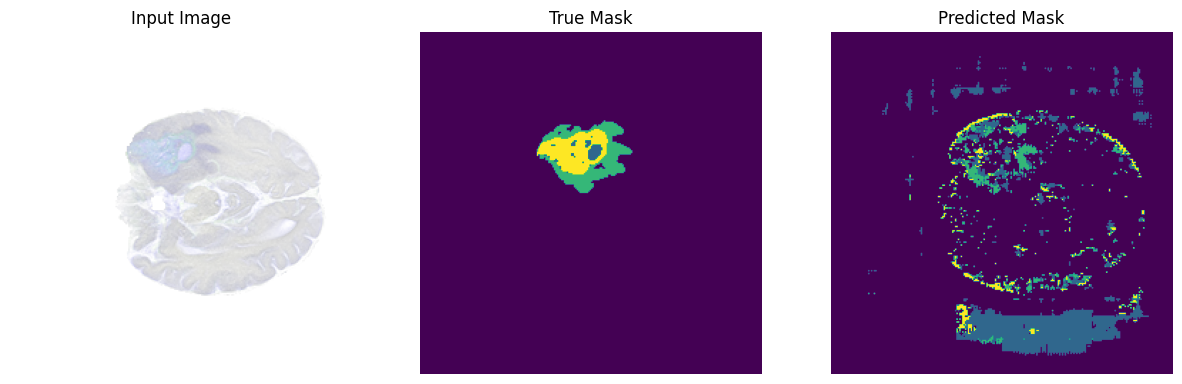

In [103]:
show_predictions(single_ds)